## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error, mean_absolute_error
from matplotlib import ticker
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima

In [2]:
df = pd.read_csv("PFE-Pfizer.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,41.375713,41.546490,41.072105,41.138519,33.265743,26667781
1,2019-03-04,41.214420,41.356735,40.683113,40.863377,33.043259,22805820
2,2019-03-05,40.882355,41.034157,40.654648,40.692600,32.905163,26529812
3,2019-03-06,40.626186,40.673622,39.487667,39.715370,32.114948,22410359
4,2019-03-07,39.715370,39.743832,39.136623,39.269451,31.754372,29046132
...,...,...,...,...,...,...,...
1318,2024-05-24,28.670000,28.990000,28.549999,28.879999,28.879999,22576300
1319,2024-05-28,28.799999,28.879999,28.129999,28.299999,28.299999,32371200
1320,2024-05-29,28.160000,28.170000,27.690001,27.820000,27.820000,24241700
1321,2024-05-30,27.910000,28.200001,27.790001,28.200001,28.200001,23330700


## Reset index

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [4]:
# Select the Close column as the dependent variable
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

## Data normalization

In [5]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

## Data splitting

In [6]:
# Split the data into training, validation and test dataset in a ratio of 6:4
train_size = int(0.6 * len(data_scaled))
test_size = len(data_scaled) - train_size

train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

## Model training and testing

## Training process

In [7]:
# Preparing training data
x_train = np.arange(train_size).reshape(-1, 1)
y_train = train_data.reshape(-1)

In [8]:
# Find the best ARIMA model using auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3944.676, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3945.266, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3947.592, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3947.220, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3947.111, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3946.327, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3945.781, Time=0.71 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3944.525, Time=0.59 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-3949.409, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-3948.157, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3946.370, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-3949.038, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-3950.843, Time=0.47 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-3953.106, Time=0.25 sec
 ARIMA(3,1,0)(0,0,0

In [9]:
# Fit the model
model.fit(y_train)

ARIMA(order=(3, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

## Validate Processing

## Testing Processing

In [10]:
x_test = np.array(range(train_size, len(data_scaled))).reshape(-1, 1)
y_test = np.array(test_data).reshape(-1)
y_pred = model.predict(n_periods=len(y_test))

## Evaluate Model

In [11]:
# Evaluate the accuracy of test
y_test = scaler.inverse_transform(np.array([y_test]).reshape(-1, 1))
y_pred = scaler.inverse_transform(np.array([y_pred]).reshape(-1, 1))

test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_msle = mean_squared_log_error(y_test, y_pred)

print(f"MAPE on Test dataset: ", test_mape)
print(f"RMSE on Test dataset: ", test_rmse)
print(f"MSLE on Test dataset: ", test_msle)
print(f"MAE on Test dataset: ", test_mae)

MAPE on Test dataset:  0.3359215396600263
RMSE on Test dataset:  13.125653224139556
MSLE on Test dataset:  0.10966497842769019
MAE on Test dataset:  10.680963499298946


# Predicting the next 30 days

## Preparing the prediction data

In [12]:
# The process of creating index predict next 30 days
last_index = df_Close.index[-1]

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index + 1, last_index + 31)).reshape(-1, 1)

## Prediction process

In [13]:
# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))
y_next_30_days = scaler.inverse_transform(np.array([y_next_30_days]).reshape(-1, 1))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days.flatten())

Predicted closing prices for the next 30 days:
[48.96459438 48.90532887 48.83599445 48.82343206 48.81542005 48.80814909
 48.80704992 48.80600173 48.80526311 48.80516143 48.80502921 48.80495648
 48.80494607 48.80492999 48.80492304 48.80492184 48.80491995 48.80491931
 48.80491916 48.80491894 48.80491888 48.80491886 48.80491884 48.80491883
 48.80491883 48.80491883 48.80491883 48.80491883 48.80491883 48.80491883]


## Preparing the forecast date index

In [14]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

## Visualization

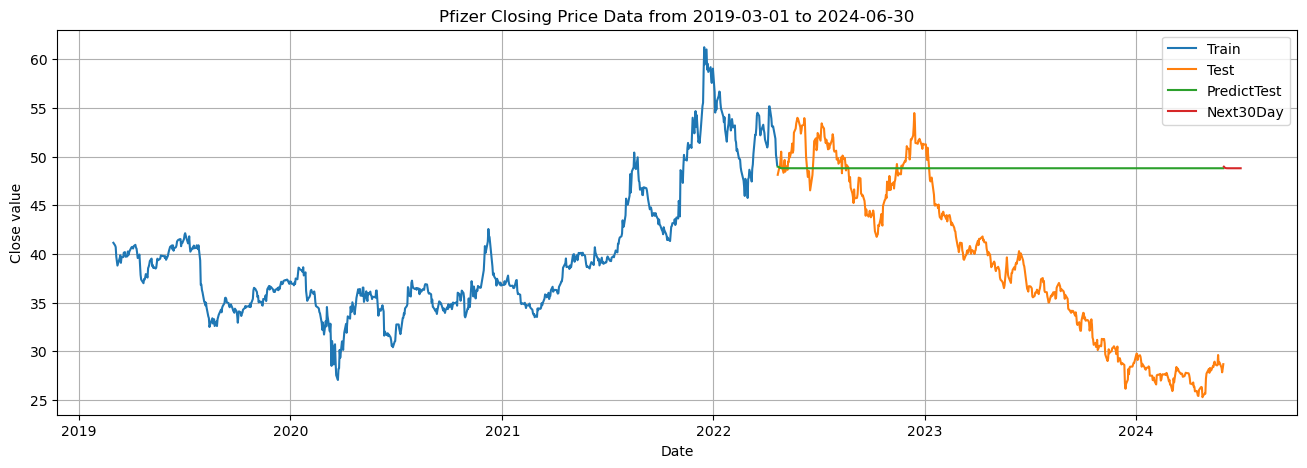

In [15]:
# Drawing
plt.figure(figsize=(16, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(np.array([y_train]).reshape(-1, 1)))
plt.plot(df.index[train_size:], y_test)
plt.plot(df.index[train_size:], y_pred)
plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Test', 'PredictTest', 'Next30Day'])
plt.grid()
plt.title(f"Pfizer Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('image/ARIMA_64_30day_PFE.png')
plt.show()